# Geospatical Area Perimeter Estimation

## Introduction

Using RGB-PanSharpen data as the primary input for building footprint extraction because it offers a balance of high resolution and color information. The RGB-PanSharpen data is a combination of the panchromatic band and the red, green, and blue bands. The panchromatic band has a higher resolution than the multispectral bands, so the RGB-PanSharpen data has a higher resolution than the multispectral data. The RGB-PanSharpen data is also in color, so it provides more information than the panchromatic band alone.

We'll be calculating the area and perimeter of the buildings in the given image. To do this we'll need the Ground Surface Distance (GSD) of the image. The GSD is the distance between two consecutive pixel centers measured on the ground. The GSD is calculated as follows: Image Width (m) / Number of Pixels in Width. Using the aforementioned formula we know each tile is 200x200m and the image is 650x650 pixels. So the GSD is 0.3077m or 0.31m

## Approach

Since we have the GSD, image size, and mask. All we need to do to estimate size is create a model that generate a mask for the buildings in the image. Then we can calculate the area and perimeter of the buildings in the mask.

1. Load the TIFF images and corresponding building footprints (GeoJSON).
2. Preprocess the images
3. Convert footprints into binary masks (rasterize GeoJSON).
4. Train a segmentation model (ResNeXt + UNet).
5. Compute area and perimeter from the predicted mask.




## Imports 

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models
!pip install --upgrade tensorflow keras
!pip install git+https://github.com/qubvel/classification_models.git

In [4]:
from PIL import Image
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import re
import glob
import rasterio

os.environ["SM_FRAMEWORK"] = "tf.keras"
import tensorflow as tf
import segmentation_models as sm

from skimage.measure import label, regionprops
from rasterio.transform import Affine
from rasterio import warp, features
from rasterio.warp import calculate_default_transform, reproject, Resampling

2025-01-29 22:24:05.847565: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-29 22:24:05.851164: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-29 22:24:05.862704: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738189445.882392    2545 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738189445.888256    2545 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-29 22:24:05.908290: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Segmentation Models: using `tf.keras` framework.


## Download Dataset

In [4]:
%%bash
aws s3 cp s3://spacenet-dataset/spacenet/SN2_buildings/tarballs/AOI_2_Vegas_Test_public.tar.gz dataset/backups/

download: s3://spacenet-dataset/spacenet/SN2_buildings/tarballs/AOI_2_Vegas_Test_public.tar.gz to dataset/backups/AOI_2_Vegas_Test_public.tar.gz


In [5]:
%%bash
aws s3 cp s3://spacenet-dataset/spacenet/SN2_buildings/tarballs/SN2_buildings_train_AOI_2_Vegas.tar.gz dataset/backups/

download: s3://spacenet-dataset/spacenet/SN2_buildings/tarballs/SN2_buildings_train_AOI_2_Vegas.tar.gz to dataset/backups/SN2_buildings_train_AOI_2_Vegas.tar.gz


In [6]:
%%bash
tar -xzf dataset/backups/AOI_2_Vegas_Test_public.tar.gz -C dataset/

In [7]:
%%bash
tar -xzf dataset/backups/SN2_buildings_train_AOI_2_Vegas.tar.gz -C dataset/

## Preprocessing

* each image should be 650x650 pixels but converted to 640x640
* Normalize pixel values to a range 0-255 for normal viewing

In [5]:
# Paths to training and testing datasets

# Train Images and Masks
train_folder = "dataset/AOI_2_Vegas_Train/RGB-PanSharpen"
train_masks_folder  = "dataset/AOI_2_Vegas_Train/geojson/buildings"

# Processed Training Images and Masks
processed_train_folder = "dataset/processed_images/AOI_2_Vegas_Train/RGB-PanSharpen-processed"
processed_mask_folder = "dataset/processed_masks/AOI_2_Vegas_Train/geojson"

# Test Images
test_folder = "dataset/AOI_2_Vegas_Test_public/RGB-PanSharpen"
processed_test_folder = "dataset/processed_images/AOI_2_Vegas_Test_public/RGB-PanSharpen-processed"

In [6]:
os.makedirs(processed_train_folder, exist_ok=True)
os.makedirs(processed_test_folder,  exist_ok=True)
os.makedirs(processed_mask_folder,  exist_ok=True)

In [7]:
# Function to normalize a band to 0–1
def normalize_band(band):
    return (band - band.min()) / (band.max() - band.min())


In [8]:
def preprocess_tiff(image_path, out_folder):
    """
    Preprocess a TIFF image:
    1. Reads each band and normalizes it to [0, 255].
    2. Resamples to 640×640 using bilinear interpolation while **maintaining the original bounding box.
    3. Saves as uint8 GeoTIFF in 'out_folder'.
    4. Returns the processed image path.
    """

    os.makedirs(out_folder, exist_ok=True)
    filename = os.path.basename(image_path)
    out_path = os.path.join(out_folder, filename)

    def normalize_band(band):
        """Normalize band to [0, 255] while avoiding zero-range scaling issues."""
        band_min, band_max = band.min(), band.max()
        if band_max == band_min:
            return np.full_like(band, 128, dtype=np.uint8)  # Mid-gray if all values are identical
        return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)

    with rasterio.open(image_path, "r") as src:
        meta = src.meta.copy()
        original_transform = src.transform
        original_crs = src.crs
        original_width, original_height = src.width, src.height

        # Target size (fixed to 640x640)
        target_width, target_height = 640, 640

        # Compute new pixel size so the bounding box remains unchanged
        new_pixel_size_x = (original_transform.a * original_width) / float(target_width)
        new_pixel_size_y = (original_transform.e * original_height) / float(target_height)

        # Preserve original bounding box (top-left corner stays fixed)
        new_transform = Affine(
            new_pixel_size_x, 
            original_transform.b, 
            original_transform.c,
            original_transform.d, 
            new_pixel_size_y, 
            original_transform.f
        )

        print(f"[INFO] Resizing {filename}: {original_width}x{original_height} -> {target_width}x{target_height}")
        print(f"[INFO] Keeping bounding box from {original_transform.c, original_transform.f}")

        # Prepare array for resized bands
        resized_bands = np.zeros((src.count, target_height, target_width), dtype=np.uint8)

        # Reproject each band
        for i in range(src.count):
            source_band = normalize_band(src.read(i + 1))
            destination = np.empty((target_height, target_width), dtype=np.float32)

            reproject(
                source=source_band,
                destination=destination,
                src_transform=original_transform,
                src_crs=original_crs,
                dst_transform=new_transform,
                dst_crs=original_crs,
                resampling=Resampling.bilinear
            )

            np.clip(destination, 0, 255, out=destination)  # Clamp values to avoid overflow
            resized_bands[i] = destination.astype(np.uint8)

        # Update metadata
        meta.update({
            "width": target_width,
            "height": target_height,
            "dtype": "uint8",
            "transform": new_transform,
            "crs": original_crs
        })

        with rasterio.open(out_path, "w", **meta) as dst:
            for i in range(resized_bands.shape[0]):
                dst.write(resized_bands[i], i + 1)

    print(f"[INFO] Saved preprocessed image: {out_path}")
    return out_path


In [9]:
def rasterize_geojson(geojson_path, reference_tif_path, out_mask_path, all_touched=True):
    """
    Rasterizes a GeoJSON file to match the width, height, transform, and CRS of a reference TIFF.
    - Converts GeoJSON CRS if needed before rasterizing.
    - Outputs a single-band, dtype=uint8 mask where:
        1 = building footprint, 0 = background.
    """

    if not os.path.isfile(geojson_path):
        print(f"[Warning] GeoJSON not found: {geojson_path}")
        return
    if not os.path.isfile(reference_tif_path):
        print(f"[Warning] Reference TIFF not found: {reference_tif_path}")
        return

    # Open reference (resized) TIFF
    with rasterio.open(reference_tif_path) as ref_src:
        ref_transform = ref_src.transform
        ref_crs = ref_src.crs
        width, height = ref_src.width, ref_src.height

    print(f"[INFO] Processing mask for {geojson_path}")
    print(f"[INFO] Reference: {reference_tif_path}")
    print(f"[INFO] Transform: {ref_transform}")
    print(f"[INFO] Size: {width}x{height}")

    # Load GeoJSON
    gdf = gpd.read_file(geojson_path)

    # Ensure CRS matches
    if gdf.crs != ref_crs:
        print(f"[INFO] CRS mismatch: GeoJSON ({gdf.crs}) vs TIFF ({ref_crs}). Reprojecting...")
        gdf = gdf.to_crs(ref_crs)

    # Prepare (geometry, value) pairs
    shapes = [(geom, 1) for geom in gdf.geometry if geom is not None]

    # Rasterize
    mask_array = features.rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=ref_transform,
        fill=0,
        all_touched=all_touched,
        dtype=np.uint8
    )

    print("Unique values in mask after rasterization:", np.unique(mask_array))

    # Save mask
    mask_meta = {
        "driver": "GTiff",
        "height": height,
        "width": width,
        "count": 1,
        "dtype": "uint8",
        "crs": ref_crs,
        "transform": ref_transform
    }

    with rasterio.open(out_mask_path, "w", **mask_meta) as dst:
        dst.write(mask_array, 1)

    print(f"[INFO] Mask saved: {out_mask_path}")

In [10]:
def preprocess_folder_images_only(in_image_folder, out_image_folder):
    """
    Preprocess each TIFF in 'in_image_folder' (normalize, resample) and save to 'out_image_folder'.
    No GeoJSON handling.
    """
    os.makedirs(out_image_folder, exist_ok=True)

    for file in os.listdir(in_image_folder):
        if file.endswith(".tif"):
            tiff_path = os.path.join(in_image_folder, file)
            print(f"Preprocessing: {tiff_path}")
            preprocess_tiff(tiff_path, out_image_folder)

    print(f"\nAll TIFFs in {in_image_folder} have been processed.")
    print(f"Processed images in: {out_image_folder}")

In [11]:
def preprocess_folder_images_and_geojsons(
    in_image_folder, out_image_folder,
    in_geojson_folder, out_geojson_folder
):
    """
    Processes each TIFF in 'in_image_folder' by:
      1) Preprocessing the image (resizes to 650×650).
      2) Finding a corresponding GeoJSON.
      3) Rasterizing the GeoJSON to a mask.
    """

    os.makedirs(out_image_folder, exist_ok=True)
    os.makedirs(out_geojson_folder, exist_ok=True)

    for file in os.listdir(in_image_folder):
        if file.lower().endswith(".tif"):
            tiff_path = os.path.join(in_image_folder, file)

            # 1) Preprocess the TIFF
            out_tiff_path = preprocess_tiff(tiff_path, out_image_folder)

            # 2) Match the corresponding GeoJSON by "imgXXXX"
            match = re.search(r"img\d+", file)
            if not match:
                print(f"[Warning] Could not extract 'imgXXXX' from filename: {file}")
                continue

            img_id = match.group(0)
            matched_geojson = next(
                (gf for gf in os.listdir(in_geojson_folder) if gf.lower().endswith(".geojson") and img_id in gf), None
            )

            if not matched_geojson:
                print(f"[Warning] No GeoJSON found for {file}")
                continue

            geojson_path = os.path.join(in_geojson_folder, matched_geojson)
            out_mask_name = os.path.splitext(file)[0] + "_mask.tif"
            out_mask_path = os.path.join(out_geojson_folder, out_mask_name)

            # 3) Rasterize the GeoJSON to match the TIFF
            rasterize_geojson(geojson_path, out_tiff_path, out_mask_path)

    print(f"\n[INFO] Processed TIFFs: {out_image_folder}")
    print(f"[INFO] Rasterized masks: {out_geojson_folder}")

In [12]:
# Run preprocessing on training and testing datasets
preprocess_folder_images_and_geojsons(
    train_folder,
    processed_train_folder,
    train_masks_folder,
    processed_mask_folder
)

[INFO] Resizing RGB-PanSharpen_AOI_2_Vegas_img5624.tif: 650x650 -> 640x640
[INFO] Keeping bounding box from (-115.1706276, 36.2406177)
[INFO] Saved preprocessed image: dataset/processed_images/AOI_2_Vegas_Train/RGB-PanSharpen-processed/RGB-PanSharpen_AOI_2_Vegas_img5624.tif
[INFO] Processing mask for dataset/AOI_2_Vegas_Train/geojson/buildings/buildings_AOI_2_Vegas_img5624.geojson
[INFO] Reference: dataset/processed_images/AOI_2_Vegas_Train/RGB-PanSharpen-processed/RGB-PanSharpen_AOI_2_Vegas_img5624.tif
[INFO] Transform: | 0.00, 0.00,-115.17|
| 0.00,-0.00, 36.24|
| 0.00, 0.00, 1.00|
[INFO] Size: 640x640
Unique values in mask after rasterization: [0 1]
[INFO] Mask saved: dataset/processed_masks/AOI_2_Vegas_Train/geojson/RGB-PanSharpen_AOI_2_Vegas_img5624_mask.tif
[INFO] Resizing RGB-PanSharpen_AOI_2_Vegas_img6353.tif: 650x650 -> 640x640
[INFO] Keeping bounding box from (-115.1530776, 36.1440926998)
[INFO] Saved preprocessed image: dataset/processed_images/AOI_2_Vegas_Train/RGB-PanSharpe

In [13]:
preprocess_folder_images_only(
    test_folder,
    processed_test_folder
)

Preprocessing: dataset/AOI_2_Vegas_Test_public/RGB-PanSharpen/RGB-PanSharpen_AOI_2_Vegas_img5578.tif
[INFO] Resizing RGB-PanSharpen_AOI_2_Vegas_img5578.tif: 650x650 -> 640x640
[INFO] Keeping bounding box from (-115.1706276, 36.1598876998)
[INFO] Saved preprocessed image: dataset/processed_images/AOI_2_Vegas_Test_public/RGB-PanSharpen-processed/RGB-PanSharpen_AOI_2_Vegas_img5578.tif
Preprocessing: dataset/AOI_2_Vegas_Test_public/RGB-PanSharpen/RGB-PanSharpen_AOI_2_Vegas_img4070.tif
[INFO] Resizing RGB-PanSharpen_AOI_2_Vegas_img4070.tif: 650x650 -> 640x640
[INFO] Keeping bounding box from (-115.2039726, 36.1476026998)
[INFO] Saved preprocessed image: dataset/processed_images/AOI_2_Vegas_Test_public/RGB-PanSharpen-processed/RGB-PanSharpen_AOI_2_Vegas_img4070.tif
Preprocessing: dataset/AOI_2_Vegas_Test_public/RGB-PanSharpen/RGB-PanSharpen_AOI_2_Vegas_img2510.tif
[INFO] Resizing RGB-PanSharpen_AOI_2_Vegas_img2510.tif: 650x650 -> 640x640
[INFO] Keeping bounding box from (-115.2390726, 36.184

In [14]:
def visualize_mask(mask_path):
    """
    Reads the single-band mask (0/1), rescales it to [0,255], and displays it in Matplotlib.
    """
    with rasterio.open(mask_path) as src:
        mask_data = src.read(1)  # single band -> shape: (height, width)

    # Rescale from [0,1] to [0,255]
    scaled_mask = (mask_data * 255).astype(np.uint8)

    # Plot
    # plt.figure(figsize=(6,6))
    plt.imshow(scaled_mask, cmap='gray')
    plt.title("Mask Visualization (Rescaled)")
    plt.axis('off')  # hide axes
    plt.show()

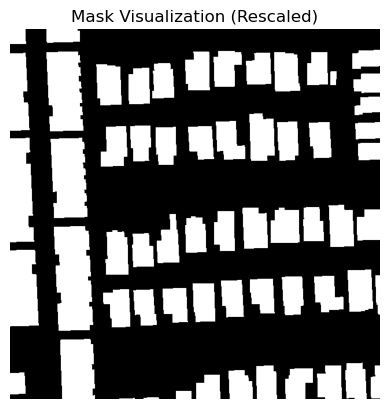

In [15]:
mask_file = "dataset/processed_masks/AOI_2_Vegas_Train/geojson/RGB-PanSharpen_AOI_2_Vegas_img1070_mask.tif"
visualize_mask(mask_file)

## Loading Data

In [16]:
train_images = []
train_masks = []

In [17]:
def load_images_and_masks(images_folder, masks_folder):
    """
    Loads preprocessed images and their corresponding masks into NumPy arrays.

    Assumes:
      - images_folder contains .tif image files
      - masks_folder contains .tif mask files
      - Each image "FILE.tif" has a corresponding "FILE_mask.tif" in masks_folder

    Returns:
      X: np.array of shape (N, H, W, C)  [images]
      Y: np.array of shape (N, H, W, 1)  [masks]
    """
    image_paths = sorted(glob.glob(os.path.join(images_folder, "*.tif")))
    X_list = []
    Y_list = []

    for img_path in image_paths:
        # 1) Read the image
        with rasterio.open(img_path) as src_img:
            img_data = src_img.read()  # (bands, height, width)
            img_data = np.transpose(img_data, (1, 2, 0))  # -> (height, width, bands)

        # 2) Build the expected mask filename
        base_name = os.path.splitext(os.path.basename(img_path))[0]  # e.g. "RGB-PanSharpen_AOI_2_Vegas_img4817"
        mask_name = base_name + "_mask.tif"                           # e.g. "RGB-PanSharpen_AOI_2_Vegas_img4817_mask.tif"
        mask_path = os.path.join(masks_folder, mask_name)

        # 3) Read the mask if it exists; else create a blank mask
        if os.path.exists(mask_path):
            with rasterio.open(mask_path) as src_mask:
                mask_data = src_mask.read(1)  # single band -> (height, width)
        else:
            # create an empty mask if none found
            h, w, _ = img_data.shape
            mask_data = np.zeros((h, w), dtype=np.uint8)

        X_list.append(img_data.astype(np.float32))
        Y_list.append(mask_data.astype(np.uint8))

    # Convert to NumPy arrays
    X = np.array(X_list, dtype=np.float32)
    Y = np.array(Y_list, dtype=np.uint8)

    # Expand dims so mask has shape (N, H, W, 1) if required by your model
    Y = np.expand_dims(Y, axis=-1)

    return X, Y


In [23]:
# Load training data

X_train, Y_train = load_images_and_masks(processed_train_folder, processed_mask_folder)

In [24]:
print("train_images.shape:", X_train.shape)
print("train_masks.shape:", Y_train.shape)

train_images.shape: (3851, 640, 640, 3)
train_masks.shape: (3851, 640, 640, 1)


## Modeling

In [25]:
sm.framework()  # just to confirm

'tf.keras'

In [26]:
# We use 'resnext50' as the encoder backbone
# classes=1 for building vs background
# activation='sigmoid' for binary segmentation
# encoder_weights='imagenet' to leverage pretraining
model_resnext = sm.Unet(
    backbone_name='resnext50',
    classes=1,
    activation='sigmoid',
    encoder_weights='imagenet',
    input_shape=(640, 640, 3) 
)

In [28]:
# Compile
model_resnext.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

model_resnext.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 640, 640,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 640, 640,  │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_18   │ (None, 646, 646,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 320, 320,  │      9,408 │ zero_padding2d_1… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 320, 320,  │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 320, 320,  │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_19   │ (None, 322, 322,  │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 160, 160,  │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 160, 160,  │      8,192 │ pooling0[0][0]    │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 160, 160,  │        512 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 160, 160,  │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_20   │ (None, 162, 162,  │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_512 (Lambda) │ (None, 162, 162,  │          0 │ zero_padding2d_2… │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_513 (Lambda) │ (None, 162, 162,  │          0 │ zero_padding2d_2… │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_514 (Lambda) │ (None, 162, 162,  │          0 │ zero_padding2d_2… │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_515 (Lambda) │ (None, 162, 162,  │          0 │ zero_padding2d_2… │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_516 (Lambda) │ (None, 162, 162,  │          0 │ zero_padding2d_2

 Total params: 32,063,194 (122.31 MB)

 Trainable params: 31,992,980 (122.04 MB)

 Non-trainable params: 70,214 (274.27 KB)

In [ ]:
history = model_resnext.fit(
    X_train, Y_train, 
    epochs=1, 
    batch_size=2,
    validation_split=0.1
)

2025-01-29 23:15:55.054873: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 17031168000 exceeds 10% of free system memory.


 214/1733 ━━━━━━━━━━━━━━━━━━━━ 1:24:15 3s/step - accuracy: 0.9191 - loss: 0.2114

In [ ]:
os.makedirs("outputs", exist_ok=True)
model_save_path = os.path.join("outputs", "unet_resnext_building_extraction.h5")

model_resnext.save(model_save_path)
print(f"Model saved to: {model_save_path}")

## Inference

In [ ]:
def load_images_only(images_folder):
    """
    Loads preprocessed images into a NumPy array.

    Args:
      images_folder (str): Directory containing .tif image files.

    Returns:
      X (np.ndarray): Array of shape (N, H, W, C), 
                      where N = number of images, 
                            H, W = image dimensions,
                            C = number of channels (bands).
    """
    image_paths = sorted(glob.glob(os.path.join(images_folder, "*.tif")))
    X_list = []

    for img_path in image_paths:
        with rasterio.open(img_path) as src_img:
            # Read all bands: shape -> (bands, height, width)
            img_data = src_img.read()
            # Transpose to (height, width, bands) for consistency
            img_data = np.transpose(img_data, (1, 2, 0))
            X_list.append(img_data.astype(np.float32))

    # Convert the list of arrays to a single NumPy array
    X = np.array(X_list, dtype=np.float32)
    return X

In [ ]:
# Load test images
X_test = load_images_only(test_folder)
print("X_train.shape ", X_train.shape)

In [ ]:
preds = model_resnext.predict(X_test)  # shape: (N, 650, 650, 1)
binary_preds = (preds > 0.5).astype('uint8')

## Area and Perimeter Calculation

In [ ]:
# GSD = 0.31 # before rescaleing
GSD = 0.156

def compute_area_perimeter(mask_2d, pixel_size=GSD):
    """
    mask_2d: np.array of shape (H, W), binary (0/1)
    pixel_size: ground sampling distance in meters/pixel
    """
    labeled = label(mask_2d)  # identify connected components
    results = []

    for region in regionprops(labeled):
        area_px = region.area
        perimeter_px = region.perimeter

        # Convert to real-world
        area_m2 = area_px * (pixel_size ** 2)
        perimeter_m = perimeter_px * pixel_size

        results.append({
            'label': region.label,
            'area_pixels': area_px,
            'perimeter_pixels': perimeter_px,
            'area_m2': area_m2,
            'perimeter_m': perimeter_m
        })

    return results

In [ ]:
# Example after you have predictions for the test set:
# preds = model.predict(X_test)  # (N, 650, 650, 1)
# threshold to binary
# binary_preds = (preds > 0.5).astype('uint8')

for i in range(len(X_test)):
    mask_2d = binary_preds[i, :, :, 0]
    building_stats = compute_area_perimeter(mask_2d, pixel_size=GSD)
    print(f"Stats for Test Image {i+1}:")
    for stat in building_stats:
        print(stat)
    print("----------------")

## References

Van Etten, A., Lindenbaum, D., & Bacastow, T.M. (2018). SpaceNet: A Remote Sensing Dataset and Challenge Series. ArXiv, abs/1807.01232.

## Snippets

Image size: 650 x 650 (Width x Height)
Number of bands: 3
CRS: EPSG:4326
Transform: | 0.00, 0.00,-115.28|
| 0.00,-0.00, 36.18|
| 0.00, 0.00, 1.00|


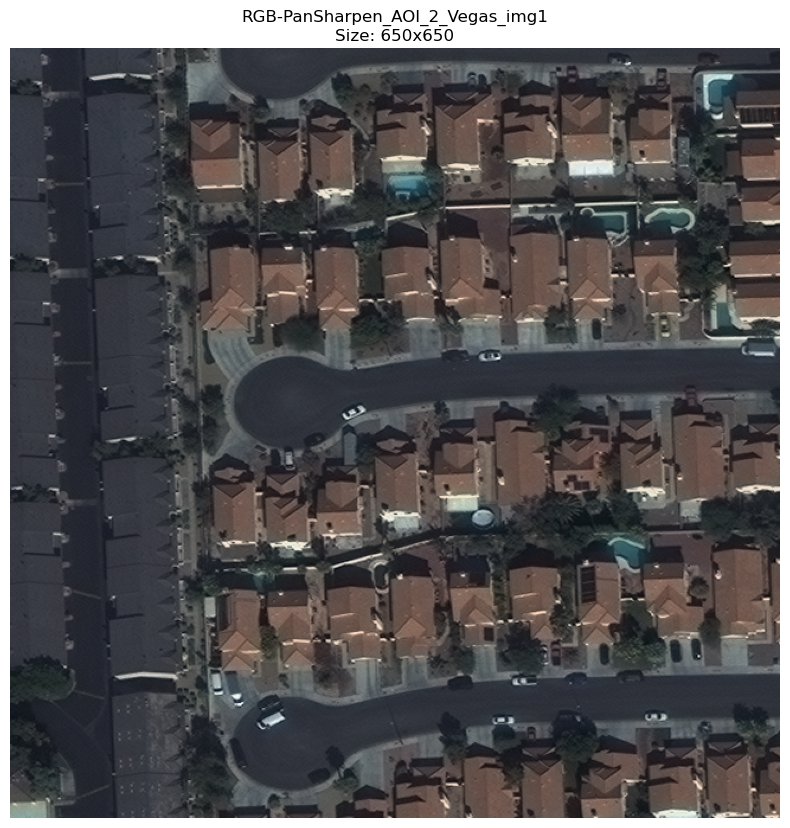

In [160]:
## Visualize the first image

import rasterio
import numpy as np
from matplotlib import pyplot as plt

# Path to the first image
image_path = "dataset/AOI_2_Vegas_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_2_Vegas_img1070.tif"

try:
    # Open the image using Rasterio
    with rasterio.open(image_path) as src:
        # Print image size and metadata
        print(f"Image size: {src.width} x {src.height} (Width x Height)")
        print(f"Number of bands: {src.count}")
        print(f"CRS: {src.crs}")
        print(f"Transform: {src.transform}")

        # Ensure the image has at least 3 bands (R, G, B)
        if src.count < 3:
            raise ValueError("The image does not have enough bands (expected at least 3).")

        # Read the first three bands (R, G, B)
        r = src.read(1)
        g = src.read(2)
        b = src.read(3)

        # Normalize each band individually to the range 0–255
        def normalize_band(band):
            return (band - band.min()) / (band.max() - band.min()) * 255

        r_normalized = normalize_band(r).astype(np.uint8)
        g_normalized = normalize_band(g).astype(np.uint8)
        b_normalized = normalize_band(b).astype(np.uint8)

        # Stack the normalized RGB bands
        rgb_normalized = np.stack((r_normalized, g_normalized, b_normalized), axis=-1)

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_normalized)
    plt.title(f"RGB-PanSharpen_AOI_2_Vegas_img1\nSize: {src.width}x{src.height}")
    plt.axis("off")
    plt.show()

except FileNotFoundError:
    print(f"Error: The file {image_path} was not found.")
except ValueError as ve:
    print(f"Error: {ve}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Image size: 650 x 650 (Width x Height)
Number of bands: 3
CRS: EPSG:4326
Transform: | 0.00, 0.00,-115.28|
| 0.00,-0.00, 36.18|
| 0.00, 0.00, 1.00|


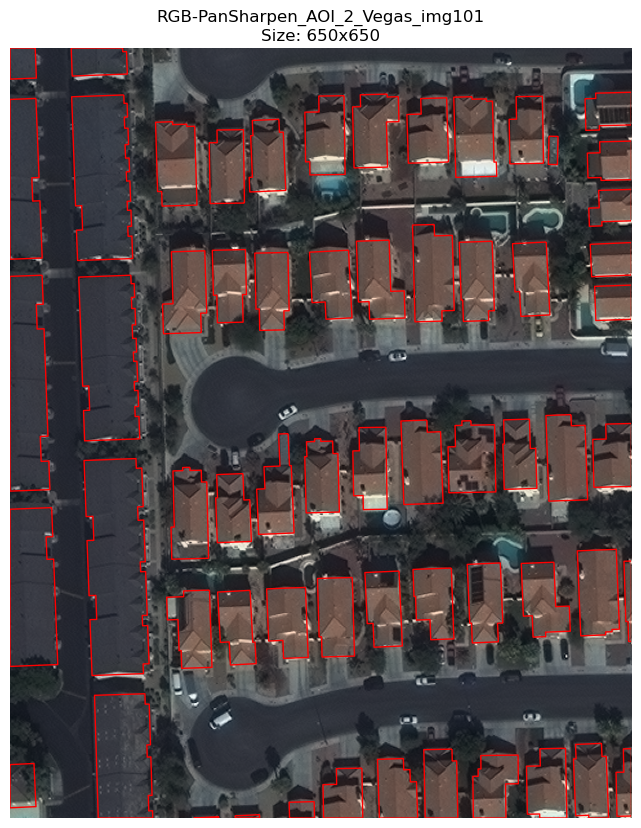

In [161]:
import rasterio
import numpy as np
import geopandas as gpd
from rasterio.plot import show
import matplotlib.pyplot as plt

# Paths to the image and geojson mask
image_path = "dataset/AOI_2_Vegas_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_2_Vegas_img1070.tif"
mask_path = "dataset/AOI_2_Vegas_Train/geojson/buildings/buildings_AOI_2_Vegas_img1070.geojson"

try:
    # Open the image using Rasterio
    with rasterio.open(image_path) as src:
        # Print image size and metadata
        print(f"Image size: {src.width} x {src.height} (Width x Height)")
        print(f"Number of bands: {src.count}")
        print(f"CRS: {src.crs}")
        print(f"Transform: {src.transform}")

        # Ensure the image has at least 3 bands (R, G, B)
        if src.count < 3:
            raise ValueError("The image does not have enough bands (expected at least 3).")

        # Read the first three bands (R, G, B)
        r = src.read(1)
        g = src.read(2)
        b = src.read(3)

        # Normalize each band individually to the range 0–255
        def normalize_band(band):
            return (band - band.min()) / (band.max() - band.min()) * 255

        r_normalized = normalize_band(r).astype(np.uint8)
        g_normalized = normalize_band(g).astype(np.uint8)
        b_normalized = normalize_band(b).astype(np.uint8)

        # Stack the normalized bands into a single array of shape (3, height, width)
        rgb_array = np.stack([r_normalized, g_normalized, b_normalized], axis=0)

        # Read the GeoJSON mask into a GeoDataFrame
        gdf = gpd.read_file(mask_path)

        # Match the GeoDataFrame's CRS to the image CRS if they differ
        if gdf.crs != src.crs:
            gdf = gdf.to_crs(src.crs)

        # Create a figure and axis for plotting
        fig, ax = plt.subplots(figsize=(10, 10))

        # Use rasterio's show function to display the georeferenced image
        show(
            rgb_array,
            transform=src.transform,
            ax=ax
        )

        # Overlay the building footprints
        # facecolor='none' makes polygons transparent, edgecolor outlines them
        gdf.plot(ax=ax, facecolor='none', edgecolor='red')

        # Set title and remove axis ticks
        plt.title(f"RGB-PanSharpen_AOI_2_Vegas_img101\nSize: {src.width}x{src.height}")
        plt.axis("off")

        # Show the figure
        plt.show()

except FileNotFoundError:
    print(f"Error: The file {image_path} or {mask_path} was not found.")
except ValueError as ve:
    print(f"Error: {ve}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Image size: 650 x 650
CRS: EPSG:4326


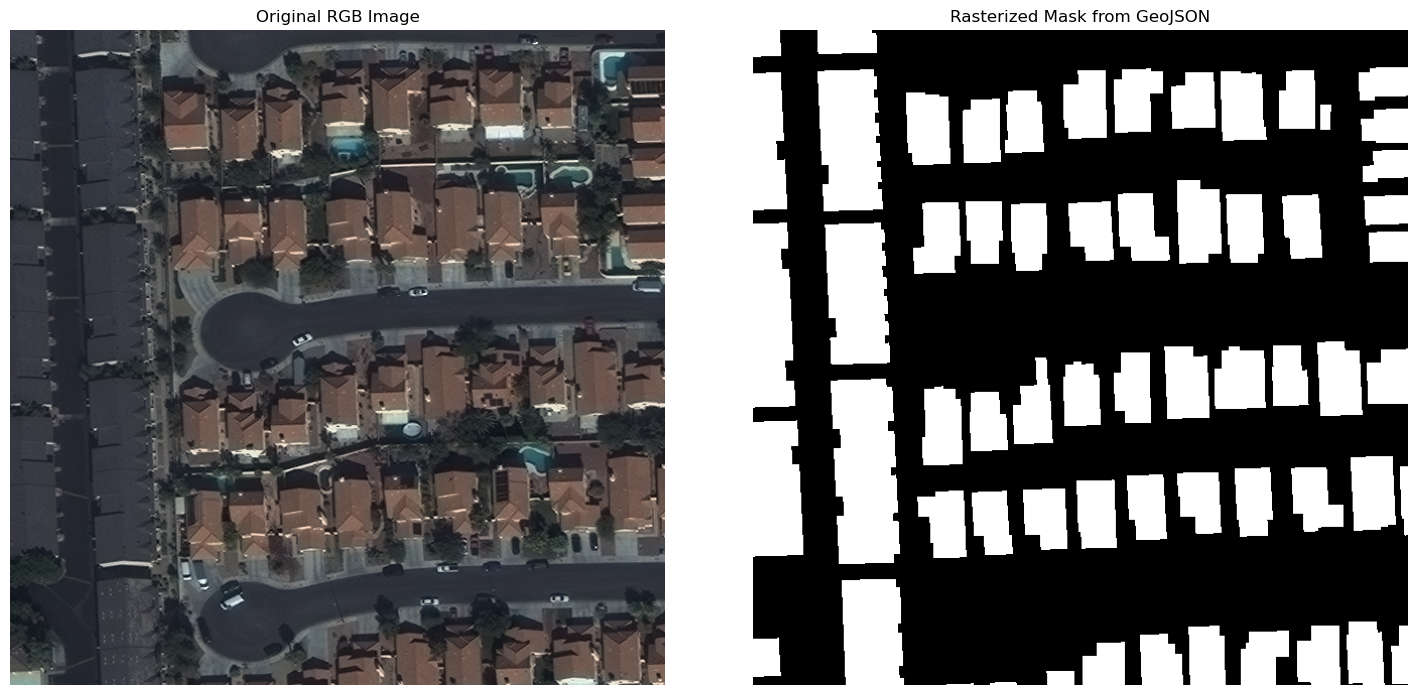

In [163]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio import features
from rasterio.plot import show

# Paths to the image and geojson
image_path = "dataset/AOI_2_Vegas_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_2_Vegas_img1070.tif"
geojson_path = "dataset/AOI_2_Vegas_Train/geojson/buildings/buildings_AOI_2_Vegas_img1070.geojson"

try:
    # 1. Open the reference image using Rasterio
    with rasterio.open(image_path) as src:
        image_crs = src.crs
        transform = src.transform
        width, height = src.width, src.height

        print(f"Image size: {width} x {height}")
        print(f"CRS: {image_crs}")

        # Read the first three bands (R, G, B) for visualization
        r, g, b = src.read(1), src.read(2), src.read(3)

        # Normalize image bands
        def normalize_band(band):
            return ((band - band.min()) / (band.max() - band.min()) * 255).astype(np.uint8)

        rgb_image = np.stack([
            normalize_band(r),
            normalize_band(g),
            normalize_band(b)
        ], axis=0)

    # 2. Load the GeoJSON and match CRS if needed
    gdf = gpd.read_file(geojson_path)
    
    if gdf.crs != image_crs:
        print(f"[Warning] GeoJSON CRS ({gdf.crs}) does not match Image CRS ({image_crs}). Reprojecting...")
        gdf = gdf.to_crs(image_crs)

    # 3. Rasterize GeoJSON to match the TIFF dimensions
    shapes = [(geom, 1) for geom in gdf.geometry if geom is not None]
    mask = np.zeros((height, width), dtype=np.uint8)

    mask = features.rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        all_touched=True,
        dtype=np.uint8
    )

    # 4. Display the image and the mask
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    # Plot the RGB image
    axes[0].set_title("Original RGB Image")
    show(rgb_image, transform=transform, ax=axes[0])
    axes[0].axis("off")

    # Plot the rasterized mask
    axes[1].set_title("Rasterized Mask from GeoJSON")
    axes[1].imshow(mask, cmap="gray")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"Error: The file {image_path} or {geojson_path} was not found.")
except ValueError as ve:
    print(f"Error: {ve}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
